# UGBA 147 Project

In [1]:
options(warn=-1)
library(IRdisplay,  verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(tidyverse,  verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(rgl,        verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(reshape2,   verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(gridExtra,  verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(kableExtra, verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(ggdendro,   verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(mclust,     verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(e1071,      verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(caret,      verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(rpart,      verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(rpart.plot, verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(kknn,       verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(neuralnet,  verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)

size = function(data) data.frame(observations=dim(data)[1], variables=dim(data)[2])

restore = list(repr.plot.width=8, repr.plot.height=4)
PALETTE = c("#00A9FF", "#F8766D", "#7CAE00", "#C77CFF", "#CD9600", "#00BE67", "#FF61CC", "#00BFC4")
theme.no_legend = theme(legend.position="none")
theme.no_x_axis_labels = theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Package 'mclust' version 5.4.3
Type 'citation("mclust")' for citing this R package in publications.


## Analyst

* Christopher Pyles

## Business Parameters

There is a budget of \\$1,000,000.

In [2]:
budget = 1000000

## Discussion

In this project, data is prepared by rendering 4 variables related to the growth of the stock price between different periods. Exploratory data analysis is performed on the data looking to find and exploit relationships between other variables and stock price growth. This includes look at correlations between growth and other variables and transformations of those variables. Principal component analysis is performed on the data in order to determine whether or not dimensionality reduction is possible.

Cluster modeling is attempted through multiple means and models, including a stochastic algorithm using hierarchical agglomeration in an attempt to converge to an optimal cluster model. Clusters are evaluted using diffusion ratios, with the model that maximizes this ratio being chosen as the final cluster model. Exploratory modeling is performed using Naive Bayes, Support Vector Machines, Neural Networks, and Ordinary Least Squares. These models are used to find an optimal predictor of growth; the best model (the one with the lowest root-mean-squared error) is then used to predict growth.

With these growth predictions, the difference between actual growth and predicted growth is used to determine if and how much a stock should be invested in. Only those stocks whose actual growth is higher than their predicted growth (meaning they outperformed expectations) are invested in, and the investment is proportional to how much better the stock performed. 

Finally, regression models are built to predict this investment amount based on numuerical data. It is these models which will be used on the new data to determine how much to invest in each stock. Models, including neual networks, SVMs of various kernels, and an OLS model, are trained on the investment data created above and then applied to the new data. The predicted prices are scaled to the budget and then the recommendations are written to a CSV file.

## Data

In this section, we load in the data files and the data dictionary.

In [3]:
data1 = read.csv("../data/Company Fundamentals 2016-Q1 A.csv")
data2 = read.csv("../data/Company Fundamentals 2016-Q2 A.csv")
data3 = read.csv("../data/Company Fundamentals 2016-Q3 A.csv")
data4 = read.csv("../data/Company Fundamentals 2016-Q4 A.csv")
prices = read.csv("../data/Company Price 2017-Q2 A.csv")

### Data Dictionary

Because the data has several variables, we load the data dictionary into R as a dataframe to make use of it later.

In [4]:
data.dictionary = read.csv("../data/Data Dictionary.csv")
data.dictionary

Variable.Name Data.Type
1   ACCHGQ        NUM      
2   ACCHGY        NUM      
3   ACCTCHGQ      CHAR     
4   ACCTSTDQ      CHAR     
5   ACOMINCQ      NUM      
6   ACOQ          NUM      
7   ACTQ          NUM      
8   ADD1          CHAR     
9   ADD2          CHAR     
10  ADD3          CHAR     
11  ADD4          CHAR     
12  ADDZIP        CHAR     
13  ADJEX         NUM      
14  ADRRQ         NUM      
15  AFUDCCY       NUM      
16  AFUDCIY       NUM      
17  AJEXQ         NUM      
18  AJPQ          NUM      
19  ALTOQ         NUM      
20  AMCY          NUM      
21  ANCQ          NUM      
22  ANOQ          NUM      
23  AOCIDERGLQ    NUM      
24  AOCIOTHERQ    NUM      
25  AOCIPENQ      NUM      
26  AOCISECGLQ    NUM      
27  AOL2Q         NUM      
28  AOLOCHY       NUM      
29  AOQ           NUM      
30  APALCHY       NUM      
⋮   ⋮             ⋮        
645 XIDOCY        NUM      
646 XIDOQ         NUM      
647 XIDOY         NUM      
648 XINTQ         NUM      
649 XINTY         NUM      
650 XIQ           NUM      
651 XIY           NUM      
652 XOPRQ         NUM      
653 XOPRY         NUM      
654 XOPT12        NUM      
655 XOPTD12       NUM      
656 XOPTD12P      NUM      
657 XOPTDQ        NUM      
658 XOPTDQP       NUM      
659 XOPTDQPY      NUM      
660 XOPTDY        NUM      
661 XOPTEPS12     NUM      
662 XOPTEPSP12    NUM      
663 XOPTEPSQ      NUM      
664 XOPTEPSQP     NUM      
665 XOPTEPSQPY    NUM      
666 XOPTEPSY      NUM      
667 XOPTQ         NUM      
668 XOPTQP        NUM      
669 XOPTQPY       NUM      
670 XOPTY         NUM      
671 XRDQ          NUM      
672 XRDY          NUM      
673 XSGAQ         NUM      
674 XSGAY         NUM      
    Variable.Description                                                               
1   ACCHGQ -- Accounting Changes - Cumulative Effect                                   
2   ACCHGY -- Accounting Changes - Cumulative Effect                                   
3   ACCTCHGQ -- Adoption of Accounting Changes                                         
4   ACCTSTDQ -- Accounting Standard                                                    
5   ACOMINCQ -- Accumulated Other Comprehensive Income (Loss)                          
6   ACOQ -- Current Assets - Other - Total                                             
7   ACTQ -- Current Assets - Total                                                     
8   ADD1 -- Address Line 1                                                             
9   ADD2 -- Address Line 2                                                             
10  ADD3 -- Address Line 3                                                             
11  ADD4 -- Address Line 4                                                             
12  ADDZIP -- Postal Code                                                              
13  ADJEX -- Cumulative Adjustment Factor by Ex-Date                                   
14  ADRRQ -- ADR Ratio                                                                 
15  AFUDCCY -- Allowance for Funds Used During Construction (Cash Flow)                
16  AFUDCIY -- Allowance for Funds Used During Construction (Investing) (Cash Flow)    
17  AJEXQ -- Adjustment Factor (Company) - Cumulative by Ex-Date                       
18  AJPQ -- Adjustment Factor (Company) - Cumulative byPay-Date                        
19  ALTOQ -- Other Long-term Assets                                                    
20  AMCY -- Amortization (Cash Flow)                                                   
21  ANCQ -- Non-Current Assets - Total                                                 
22  ANOQ -- Assets Netting & Other Adjustments                                         
23  AOCIDERGLQ -- Accum Other Comp Inc - Derivatives Unrealized Gain/Loss              
24  AOCIOTHERQ -- Accum Other Comp Inc - Other Adjustments                             
25  AOCIPENQ -- Accum Other Comp Inc - Min Pension Liab Adj         

For easy access of the data dictionary, we also define a helper function `get.col.description` which takes in a column label string and returns the description of that variable from the data dictionary.

In [5]:
get.col.description = function(col) {
    column = data.dictionary[data.dictionary$Variable.Name == toupper(col),]
    column[3]
}

# example
get.col.description("acoq")

Variable.Description                  
6 ACOQ -- Current Assets - Other - Total

## Data Cleaning

The goal of this data cleaning is to consolidate all information into a single dataframe `data`. To begin this process, we add a column `qtr` to each of the four dataframes loaded in the initialization cell indicating which quarter the data are from.

In [6]:
q12 = merge(data1, data2, by=c("gvkey", "tic", "conm"), suffixes=c(".q1", ".q2"))
q34 = merge(data3, data4, by=c("gvkey", "tic", "conm"), suffixes=c(".q3", ".q4"))
data = merge(q12, q34, by=c("gvkey", "tic", "conm"))
data = data[order(data$tic),]
head(data)

gvkey  tic   conm                        datadate.q1 fyearq.q1 fqtr.q1
2484  62527 3AMFC AMB FINANCIAL CORP          20160331    2016      1      
2715  65924 3CSBB CSB BANCORP INC/OH          20160331    2016      1      
1449  21521 3CZFS CITIZENS FINANCIAL SVCS INC 20160331    2016      1      
255  119436 3FBPI FIRST BANCORP INDIANA INC   20160331    2016      3      
2410  61225 3FETM FENTURA FINANCIAL INC       20160331    2016      1      
1105  18301 3FKYS FIRST KEYSTONE CORP         20160331    2016      1      
     fyr.q1 indfmt.q1 consol.q1 popsrc.q1 ⋯ priusa.q4 sic.q4 spcindcd.q4
2484 12     INDL      C         D         ⋯ 1         6020   840        
2715 12     INDL      C         D         ⋯ 1         6020    NA        
1449 12     INDL      C         D         ⋯ 1         6020    NA        
255   6     INDL      C         D         ⋯ 1         6020   840        
2410 12     INDL      C         D         ⋯ 1         6020    NA        
1105 12     INDL      C         D         ⋯ 1         6020    NA        
     spcseccd.q4 spcsrc.q4 state.q4 stko.q4 weburl.q4                       
2484 800         B         IN       0       www.acbanker.com                
2715  NA         NA        OH       0       www.csb1.com                    
1449  NA         NA        PA       0       www.firstcitizensbank.com       
255  800         B         IN       0       www.firstfedevansville.com      
2410  NA         B-        MI       0       www.fentura.com                 
1105  NA         NA        PA       0       www.firstkeystonecorporation.com
     dldte.q4 ipodate.q4
2484 NA       19960401  
2715 NA             NA  
1449 NA             NA  
255  NA       19990407  
2410 NA             NA  
1105 NA             NA

### Merging `data` and `prices`

Before adding the information from the `prices` dataframe, we need to remove superfluous information (all columns except for the primary key which will be used to complete the merge with the `data` dataframe). Looking at the dataframe below, we will use `tic` as the primary key and the only information not already in `data` is the `prccq` column.

In [7]:
prices = prices[order(prices$tic),]
head(prices)

gvkey  tic   conm                        prccq
2183  62527 3AMFC AMB FINANCIAL CORP          17.00
2384  65924 3CSBB CSB BANCORP INC/OH          30.60
1455  21521 3CZFS CITIZENS FINANCIAL SVCS INC 53.99
2625 119436 3FBPI FIRST BANCORP INDIANA INC   20.80
2116  61225 3FETM FENTURA FINANCIAL INC       18.25
1139  18301 3FKYS FIRST KEYSTONE CORP         27.00

#### Rendered Variable: Growth

Before adding this information, we create four random variables to indicate the growth between Q1 and Q2, Q2 and Q3, Q3 and Q4, and Q4 and 2017 Q2.

In [8]:
prices$growth.1 = data$prccq.q2 / data$prccq.q1
prices$growth.2 = data$prccq.q3 / data$prccq.q2
prices$growth.3 = data$prccq.q4 / data$prccq.q3
prices$growth.4 = prices$prccq / data$prccq.q4
head(prices)

gvkey  tic   conm                        prccq growth.1  growth.2 
2183  62527 3AMFC AMB FINANCIAL CORP          17.00 1.0079194 1.0515873
2384  65924 3CSBB CSB BANCORP INC/OH          30.60 1.0391753 0.9988095
1455  21521 3CZFS CITIZENS FINANCIAL SVCS INC 53.99 1.0680628 0.9882353
2625 119436 3FBPI FIRST BANCORP INDIANA INC   20.80 1.0412698 1.0060976
2116  61225 3FETM FENTURA FINANCIAL INC       18.25 0.9016949 1.0902256
1139  18301 3FKYS FIRST KEYSTONE CORP         27.00 0.9611538 0.9803922
     growth.3 growth.4 
2183 1.132075 1.1333333
2384 1.231625 0.9870968
1455 1.051587 1.0186792
2625 1.143030 1.1028632
2116 1.103448 1.1406250
1139 1.004082 1.0975610

To merge the dataframes, we call the `merge` function using the `tic` column as the primary key. We also rename the `prccq` column from `prices` to `prccq.2017q2` because another column called `prccq` already exists in the `data` dataframe.

In [9]:
data = merge(data, prices, by=c("gvkey", "tic", "conm"), suffixes="")
names(data)[ncol(data)-4] = "prccq.2017q2"
data

gvkey  tic     conm                         datadate.q1 fyearq.q1 fqtr.q1
1     10000 SMP     STANDARD MOTOR PRODS         20160331    2016      1      
2     10002 CAA     CALATLANTIC GROUP INC        20160331    2016      1      
3    100075 RENX    RELX NV                      20160331    2016      1      
4    100080 BAYRY   BAYER AG                     20160331    2016      1      
5    100095 BZLFY   BUNZL PLC                    20160331    2016      1      
6    100103 DLAKY   DEUTSCHE LUFTHANSA AG        20160331    2016      1      
7    100243 AMCRY   AMCOR LTD                    20160331    2016      3      
8    100245 ATEYY   ADVANTEST CORP               20160331    2015      4      
9     10030 SCX     STARRETT (L.S.) CO  -CL A    20160331    2016      3      
10   100338 RELX    RELX PLC                     20160331    2016      1      
11   100363 AMEZY.1 AMEC FOSTER WHEELER PLC      20160331    2016      1      
12     1004 AIR     AAR CORP                     20160229    2015      3      
13   100418 ESALY   EISAI CO LTD                 20160331    2015      4      
14   100424 JMHLY   JARDINE MATHESON HLDGS LTD   20160331    2016      1      
15   100477 JHX     JAMES HARDIE INDUSTRIES PLC  20160331    2015      4      
16    10056 SCL     STEPAN CO                    20160331    2016      1      
17   100572 PSO     PEARSON PLC                  20160331    2016      1      
18   100581 LRLCY   L'OREAL SA                   20160331    2016      1      
19   100590 EONGY   E.ON SE                      20160331    2016      1      
20   100609 CTTAY   CONTINENTAL AG               20160331    2016      1      
21   100644 FERGY   FERGUSON PLC                 20160131    2016      2      
22   100760 KGFHY   KINGFISHER PLC               20160131    2015      4      
23   100873 NLSN    NIELSEN HOLDINGS PLC         20160331    2016      1      
24   100953 RWEOY   RWE AG                       20160331    2016      1      
25    10096 PSA     PUBLIC STORAGE               20160331    2016      1      
26   101020 SEOAY   STORA ENSO OYJ               20160331    2016      1      
27   101088 CKHUY   CK HUTCHISON HOLDINGS LTD    20160331    2016      1      
28   101202 AIQUY   L'AIR LIQUIDE SA             20160331    2016      1      
29   101204 SNY     SANOFI                       20160331    2016      1      
30    10121 NAVI    NAVIENT CORP                 20160331    2016      1      
⋮    ⋮      ⋮       ⋮                            ⋮           ⋮         ⋮      
2971 9317   SEIC    SEI INVESTMENTS CO           20160331    2016      1      
2972 9324   SJW     SJW GROUP                    20160331    2016      1      
2973 9346   SBR     SABINE ROYALTY TRUST         20160331    2016      1      
2974 9355   SFE     SAFEGUARD SCIENTIFICS INC    20160331    2016      1      
2975 9393   SJT     SAN JUAN BASIN ROYALTY TR    20160331    2016      1      
2976 9445   SCG     SCANA CORP                   20160331    2016      1      
2977 9465   SLB     SCHLUMBERGER LTD             20160331    2016      1      
2978 9466   SCHL    SCHOLASTIC CORP              20160229    2015      3      
2979 9472   SHLM    SCHULMAN (A.) INC            20160229    2016      2      
2980 9490   SCND    SCIENTIFIC INDUSTRIES INC    20160331    2016      3      
2981 9538   SEB     SEABOARD CORP                20160331    2016      1      
2982 9555   SEE     SEALED AIR CORP              20160331    2016      1      
2983 9590   IIN     INTRICON CORP                20160331    2016      1      
2984 9599   SMTC    SEMTECH CORP                 20160131    2015      4      
2985 9611   SCI     SERVICE CORP INTERNATIONAL   20160331    2016      1      
2986 9647   SAWLF   SHAWCOR LTD                  20160331    2016      1      
2987 9664   SHEN    SHENANDOAH TELECOMMUN CO     20160331    2016      1      
2988 9667   SHW     SHERWIN-WILLIAMS CO          20160331    2016      1      
2989 9698   SIF     SIFCO INDUSTRIES             201603

### Dates

For easier time series analysis, we also convert the integer dates in the `datadate` and `ipodate` columns to Date objects. Because the IPO date for each firm is the same, we remove the `ipodate.qx` columns and replace them with a single `ipodate` column.

In [10]:
data$datadate.q1 = as.Date(as.character(data$datadate.q1), "%Y%m%d")
data$datadate.q2 = as.Date(as.character(data$datadate.q2), "%Y%m%d")
data$datadate.q3 = as.Date(as.character(data$datadate.q3), "%Y%m%d")
data$datadate.q4 = as.Date(as.character(data$datadate.q4), "%Y%m%d")
data$ipodate = as.Date(as.character(data$ipodate.q1), "%Y%m%d")
data$ipodate.q1 = NULL
data$ipodate.q2 = NULL
data$ipodate.q3 = NULL
data$ipodate.q4 = NULL

head(data)

gvkey  tic   conm                  datadate.q1 fyearq.q1 fqtr.q1 fyr.q1
1  10000 SMP   STANDARD MOTOR PRODS  2016-03-31  2016      1       12    
2  10002 CAA   CALATLANTIC GROUP INC 2016-03-31  2016      1       12    
3 100075 RENX  RELX NV               2016-03-31  2016      1       12    
4 100080 BAYRY BAYER AG              2016-03-31  2016      1       12    
5 100095 BZLFY BUNZL PLC             2016-03-31  2016      1       12    
6 100103 DLAKY DEUTSCHE LUFTHANSA AG 2016-03-31  2016      1       12    
  indfmt.q1 consol.q1 popsrc.q1 ⋯ state.q4 stko.q4 weburl.q4               
1 INDL      C         D         ⋯ NY       0       www.smpcorp.com         
2 INDL      C         D         ⋯ VA       0       www.calatlantichomes.com
3 INDL      C         D         ⋯ NA       0       www.relx.com            
4 INDL      C         D         ⋯ NA       3       www.bayer.com           
5 INDL      C         D         ⋯ NA       3       www.bunzl.com           
6 INDL      C         D         ⋯ NA       3       www.lufthansagroup.com  
  dldte.q4 prccq.2017q2 growth.1  growth.2  growth.3  growth.4  ipodate   
1 NA        52.220      1.1480519 1.2006033 1.1143216 0.9812101 <NA>      
2 NA        35.350      1.0984440 0.9109235 1.0170455 1.0394002 <NA>      
3 NA        20.680      0.9931546 1.0258472 0.9384099 1.2338902 <NA>      
4 NA       129.110      0.8493905 1.0051507 1.0403678 1.2348170 <NA>      
5 NA        29.720      1.0583279 0.9624346 0.8799001 1.1404451 1998-10-29
6 NA        22.726      0.7226787 0.9515302 1.1626988 1.7559883 <NA>

### `NA` values

To get an idea of what we are looking at in terms of `NA` values, we create a named vector of integers to indicate the number of `NA` values in each column (for reference).

In [11]:
na.sums = colSums(is.na(data))
na.sums

gvkey           tic          conm   datadate.q1     fyearq.q1 
            0             0             0             0             0 
      fqtr.q1        fyr.q1     indfmt.q1     consol.q1     popsrc.q1 
            0             0             0             0             0 
   datafmt.q1      cusip.q1   acctchgq.q1   acctstdq.q1      adrrq.q1 
            0             0          3000             7          2803 
     ajexq.q1       ajpq.q1      bsprq.q1    compstq.q1     curcdq.q1 
            0             0          2187          2762             0 
   curncdq.q1    currtrq.q1   curuscnq.q1   datacqtr.q1   datafqtr.q1 
           58            58          2695             4             0 
    finalq.q1       ogmq.q1         rp.q1       scfq.q1       srcq.q1 
           11          2917             0           217             5 
    staltq.q1       updq.q1  apdedateq.q1     fdateq.q1     pdateq.q1 
         2999             0            80            11           822 
       rdq.q1     acchgq.q1   acomincq.q1       acoq.q1       actq.q1 
           97           433           212           487           877 
     altoq.q1       ancq.q1       anoq.q1 aociderglq.q1 aociotherq.q1 
          550           944          1125           365           288 
  aocipenq.q1 aocisecglq.q1      aol2q.q1        aoq.q1        apq.q1 
          338           294          1126           125           144 
      aqaq.q1       aqdq.q1     aqepsq.q1     aqpl1q.q1       aqpq.q1 
         2444          2485          2494          1126          2313 
    arcedq.q1   arceepsq.q1      arceq.q1        atq.q1      aul3q.q1 
         3000          3000          3000            99          1125 
 billexceq.q1     capr1q.q1     capr2q.q1     capr3q.q1    capsftq.q1 
         2919          2675          2676          2672          2799 
     capsq.q1 ceiexbillq.q1       ceqq.q1       cheq.q1        chq.q1 
          303          2918           110           119           482 
  cibegniq.q1    cicurrq.q1   ciderglq.q1     cimiiq.q1   ciotherq.q1 
          236           277           270           239           243 
    cipenq.q1        ciq.q1   cisecglq.q1   citotalq.q1      cogsq.q1 
          256           237           264           236           121 
    csh12q.q1    cshfd12.q1     cshfdq.q1      cshiq.q1     cshopq.q1 
           12            12            12           281          1338 
     cshoq.q1     cshprq.q1    cstkcvq.q1     cstkeq.q1      cstkq.q1 
           83            12           735            90           271 
     dcomq.q1       dd1q.q1     deracq.q1    deraltq.q1  derhedglq.q1 
          560           922          2362          2323          2393 
    derlcq.q1    derlltq.q1     diladq.q1     dilavq.q1       dlcq.q1 
         2275          2197            90            91           360 
     dlttq.q1        doq.q1    dpacreq.q1     dpactq.q1        dpq.q1 
          142            89          2878          1595           452 
    dpretq.q1       drcq.q1      drltq.q1      dteaq.q1      dtedq.q1 
         2861           946           703          2830          2840 
   dteepsq.q1      dtepq.q1    dvintfq.q1       dvpq.q1     epsf12.q1 
         2845          2788          2794            93           120 
   epsfi12.q1     epsfiq.q1     epsfxq.q1    epspi12.q1     epspiq.q1 
          120            91            91           120            91 
    epspxq.q1     epsx12.q1    esopctq.q1    esopnrq.q1     esoprq.q1 
           91           120           463           546           551 
    esoptq.q1      esubq.q1       fcaq.q1       ffoq.q1    finacoq.q1 
          453          2947          2006          2859          2987 
    finaoq.q1     finchq.q1    findlcq.q1    findltq.q1   finivstq.q1 
         2985          2983          2987          2983          2993 
   finlcoq.q1    finltoq.q1     finnpq.q1   finreccq.q1  finrecltq.q1 
         2989          2989          2986          2975          2980 
   finrevq.q1   finxintq.q1   fi

## Exploratory Data Analysis

In this section we generate data visualizations to explore the relationships between the variables in data. To begin, we define a helper function `drop.col.na` to remove rows from a dataframe where _a single column_ has `NA` values.

In [12]:
drop.col.na = function(col) {
    no.na.data = data[!is.na(data[,paste0(col, ".q1")]),]
    for (q in c(".q2", ".q3", ".q4")) {
        no.na.data = no.na.data[!is.na(no.na.data[,paste0(col, q)]),]
    }
    no.na.data
}

### Growth vs. IPO Date

In the plot below, we plot time series data to see if there is a relationship between when a stock had its IPO and the growth from Q4 2016 to Q2 2017.

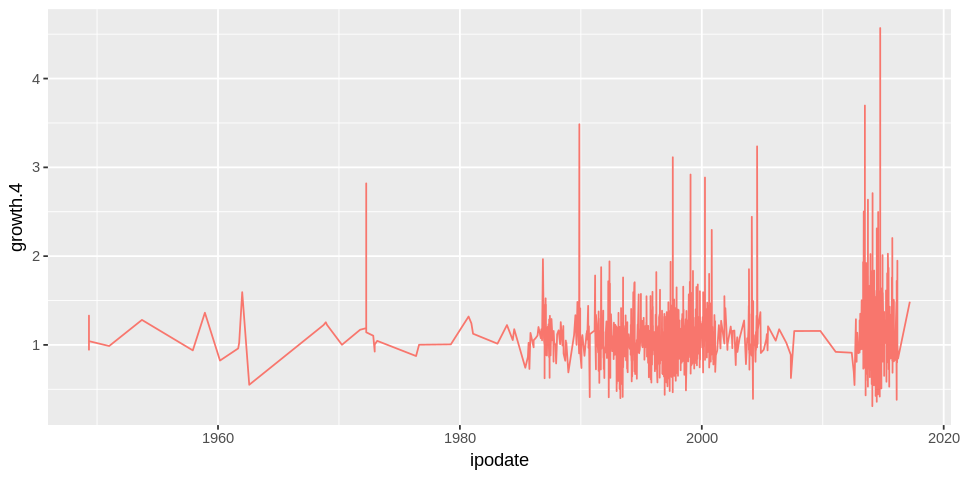

In [13]:
ipo.date = data[!is.na(data$ipodate),]
options(restore)
ggplot(ipo.date) +
    geom_line(aes(x=ipodate, y=growth.4), color=PALETTE[2])

### Stock Price vs. Growth

The scatterplot below plots the stock price in Q2 2017 against the growth. As shown in the title, the correlation is low, with $r \approx 0.058$.

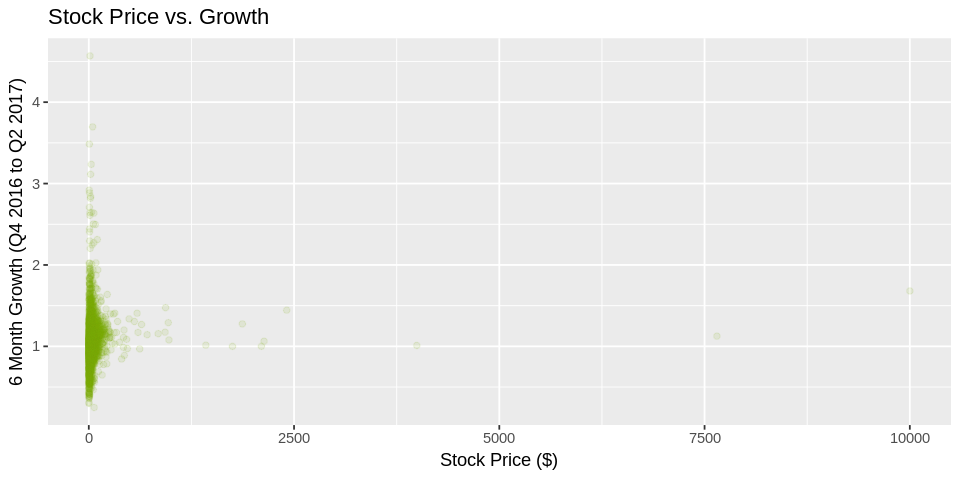

In [14]:
ggplot(data) +
    geom_point(aes(x=prccq.2017q2, y=growth.4), alpha=0.1, color=PALETTE[3]) +
    ggtitle("Stock Price vs. Growth") +
    ylab("6 Month Growth (Q4 2016 to Q2 2017)") + xlab("Stock Price ($)")

### Growth Trends

In the cell below, we melt the data and then pass it to `dcast` so that we get a dataframe with `tic` values as columns, growth variables as rows, and values indicating the growth value for that `tic` value.

In [15]:
growth.by.tic = dcast(melt(data[,c("tic", "growth.1", "growth.2", "growth.3", "growth.4")]), variable ~ tic)
growth.by.tic

Using tic as id variables


variable 3AMFC    3CSBB     3CZFS     3FBPI    3FETM     3FKYS     3HLFN    
1 growth.1 1.007919 1.0391753 1.0680628 1.041270 0.9016949 0.9611538 1.0611165
2 growth.2 1.051587 0.9988095 0.9882353 1.006098 1.0902256 0.9803922 1.0888889
3 growth.3 1.132075 1.2316250 1.0515873 1.143030 1.1034483 1.0040816 1.2015827
4 growth.4 1.133333 0.9870968 1.0186792 1.102863 1.1406250 1.0975610 0.9532062
  3JUVF     3KSBI    ⋯ SNH       SNHY      SNMSF    SNN       SNP      
1 1.0016911 1.148180 ⋯ 1.1643376 0.8945466 1.161726 1.0300120 1.1051420
2 1.0551491 1.161504 ⋯ 1.0902544 1.0868979 1.174859 0.9551282 1.0256944
3 0.9733333 1.174603 ⋯ 0.8335535 1.2386117 1.028106 0.9176327 0.9616791
4 1.0695890 1.275676 ⋯ 1.0797676 1.0675507 1.202237 1.1585771 1.1067305
  SNPS     SNR       SNV      SNX       SNY      
1 1.107692 1.0368932 1.002767 0.9688397 1.0420817
2 1.139731 1.0805243 1.122111 1.1654226 0.9125448
3 1.095089 0.8483536 1.262834 1.1011585 1.0589159
4 1.242624 1.0265577 1.076923 0.9516722 1.1847181

#### General Trend

In the cell below, we plot a bar chart of the row means of `growth.by.tic` to look at the general trend among the growth values.

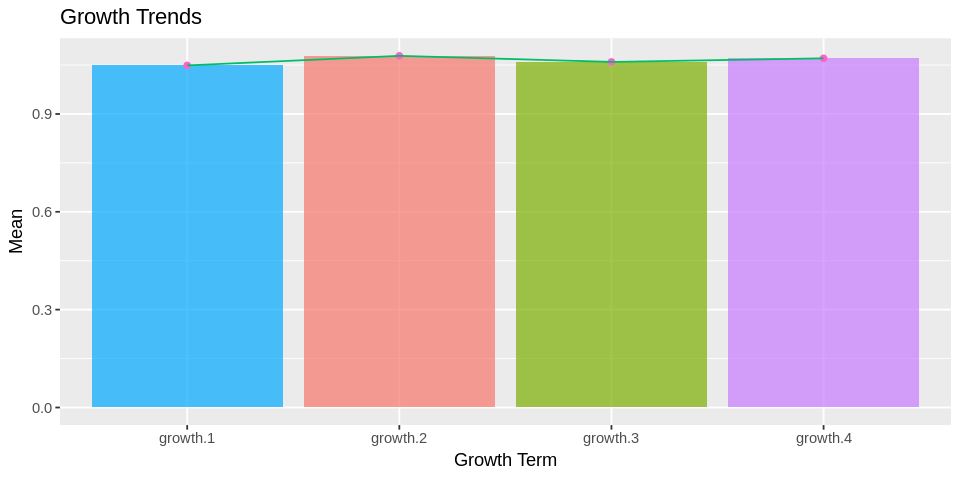

In [16]:
growth.trends = data.frame(
    variable = growth.by.tic$variable,
    mean = rowMeans(growth.by.tic[-1])
)
ggplot(growth.trends) +
    geom_col(aes(x=variable, y=mean), fill=PALETTE[1:4], alpha=0.7) +
    geom_point(aes(x=variable, y=mean), color=PALETTE[7]) +
    geom_line(aes(x=variable, y=mean, group=1), color=PALETTE[6]) +
    xlab("Growth Term") + ylab("Mean") + ggtitle("Growth Trends")

#### Trends Grouped by Quantiles

We want to group the observations by their growth values. We will do this by using the 20th, 40th, 60th, and 80th quantiles as boundaries and assigning each observation a number based on where its mean growth falls.

In [17]:
growth.means = colMeans(growth.by.tic[-1])

grouped.by.growth = data.frame(tic=names(growth.means), growth.mean=unname(growth.means))
quartiles = quantile(growth.means, c(.2, .4, .6, .8))

growth.to.group = function(x) {
    if (x <= quartiles[1]) {
        return(1)
    } else if (x <= quartiles[2]) {
        return (2)
    } else if (x <= quartiles[3]) {
        return (3)
    } else if (x <= quartiles[4]) {
        return (4)
    } else {
        return(5)
    }
}

groups = as.factor(unname(sapply(growth.means, growth.to.group)))
grouped.by.growth = cbind(grouped.by.growth, data.frame(group=groups))
head(grouped.by.growth)

tic   growth.mean group
1 3AMFC 1.081229    4    
2 3CSBB 1.064177    3    
3 3CZFS 1.031641    2    
4 3FBPI 1.073315    3    
5 3FETM 1.058998    3    
6 3FKYS 1.010797    2

In the cell below, we add `growth.group` to the data.

In [18]:
data = data[order(data$tic),]
data$growth.group = grouped.by.growth$group
head(data)

gvkey  tic   conm                        datadate.q1 fyearq.q1 fqtr.q1
2484  62527 3AMFC AMB FINANCIAL CORP          2016-03-31  2016      1      
2715  65924 3CSBB CSB BANCORP INC/OH          2016-03-31  2016      1      
1449  21521 3CZFS CITIZENS FINANCIAL SVCS INC 2016-03-31  2016      1      
255  119436 3FBPI FIRST BANCORP INDIANA INC   2016-03-31  2016      3      
2410  61225 3FETM FENTURA FINANCIAL INC       2016-03-31  2016      1      
1105  18301 3FKYS FIRST KEYSTONE CORP         2016-03-31  2016      1      
     fyr.q1 indfmt.q1 consol.q1 popsrc.q1 ⋯ stko.q4
2484 12     INDL      C         D         ⋯ 0      
2715 12     INDL      C         D         ⋯ 0      
1449 12     INDL      C         D         ⋯ 0      
255   6     INDL      C         D         ⋯ 0      
2410 12     INDL      C         D         ⋯ 0      
1105 12     INDL      C         D         ⋯ 0      
     weburl.q4                        dldte.q4 prccq.2017q2 growth.1  growth.2 
2484 www.acbanker.com                 NA       17.00        1.0079194 1.0515873
2715 www.csb1.com                     NA       30.60        1.0391753 0.9988095
1449 www.firstcitizensbank.com        NA       53.99        1.0680628 0.9882353
255  www.firstfedevansville.com       NA       20.80        1.0412698 1.0060976
2410 www.fentura.com                  NA       18.25        0.9016949 1.0902256
1105 www.firstkeystonecorporation.com NA       27.00        0.9611538 0.9803922
     growth.3 growth.4  ipodate    growth.group
2484 1.132075 1.1333333 1996-04-01 4           
2715 1.231625 0.9870968 <NA>       3           
1449 1.051587 1.0186792 <NA>       2           
255  1.143030 1.1028632 1999-04-07 3           
2410 1.103448 1.1406250 <NA>       3           
1105 1.004082 1.0975610 <NA>       2

### Variable Correlations with Growth

We look below at the correlations of different variables (and their transformations) with growth. The cell below looks for straightforward correlation with no transformation.

In [19]:
numeric.vars = data[, unlist(lapply(data, is.numeric))]
no.na.numeric = numeric.vars[,names(na.sums[(na.sums == 0) & (names(na.sums) %in% names(numeric.vars))])]
growth.cor = as.data.frame(cor(no.na.numeric[,names(no.na.numeric) != "cat.growth"]))$growth.4
sort(abs(growth.cor), decreasing=TRUE)

[1] 1.0000000000 0.1229835211 0.0897044924 0.0700527947 0.0700527947
 [6] 0.0630019397 0.0630019397 0.0627050789 0.0610665325 0.0606650547
[11] 0.0605783461 0.0605783461 0.0581840079 0.0535344541 0.0365271451
[16] 0.0365271451 0.0365271451 0.0365271451 0.0360107231 0.0328612080
[21] 0.0322311171 0.0321494029 0.0309946461 0.0308884446 0.0302886232
[26] 0.0301413342 0.0300909698 0.0300587437 0.0298541249 0.0298050239
[31] 0.0292289828 0.0274688708 0.0274425051 0.0268940882 0.0262053470
[36] 0.0259044872 0.0259044872 0.0259044872 0.0259044872 0.0209262393
[41] 0.0209262393 0.0209066473 0.0162589006 0.0145389054 0.0142086070
[46] 0.0142086070 0.0142086070 0.0142086070 0.0141667803 0.0138265923
[51] 0.0128543480 0.0096433823 0.0094284788 0.0090284827 0.0090284827
[56] 0.0080157308 0.0076491645 0.0063646788 0.0059881180 0.0059881180
[61] 0.0050784380 0.0050784380 0.0050784380 0.0050784380 0.0050439401
[66] 0.0041431207 0.0040851458 0.0020624743 0.0014210008 0.0008690413

There are no good linear correlates, so now we look at a few transformations of variables. The functions define below take a function and apply it to growth and then return the correlation of the other variables with that transformation of `growth.4`. **This means that if we get a high correlation between $f(\texttt{growth.4})$ and `other.var`, `growth.4` is correlated with $f^{-1}(\texttt{other.var})$ and that is what will be used in later modeling.**

<br>

#### $e^x$

In [20]:
generate.fn.col = function(fn) {
    data.2 = no.na.numeric[,names(no.na.numeric) != "cat.growth"]
    growth.fn = fn(data.2$growth.4)
    data.2$growth.fn = growth.fn
    data.2 = data.2[,names(data.2) != "growth.4"]
    data.2
}

list.cor = function(fn) {
    data.fn = generate.fn.col(fn)
    growth.cor = as.data.frame(cor(data.fn))$growth.fn
    names(growth.cor) = names(data.fn)
    sort(abs(growth.cor), decreasing=TRUE)
}

list.cor(log)

growth.fn     growth.3     growth.1     ajexq.q4     adjex.q4       sic.q1 
1.0000000000 0.1080655874 0.0963634176 0.0887321887 0.0887321887 0.0835148768 
      sic.q2       sic.q3       sic.q4      ajpq.q4     ajexq.q3     adjex.q3 
0.0835148768 0.0835148768 0.0835148768 0.0833839192 0.0785876559 0.0785876559 
     ajpq.q3      ajpq.q2     ajexq.q2     adjex.q2 prccq.2017q2     naics.q1 
0.0783594778 0.0745586811 0.0744118585 0.0744118585 0.0665605510 0.0430660397 
    naics.q2     naics.q3     naics.q4     prchq.q1     prccq.q3     prchq.q3 
0.0430660397 0.0430660397 0.0430660397 0.0406796406 0.0400128211 0.0399101808 
    prclq.q3     prclq.q4     prccq.q1     prclq.q1     prclq.q2     prchq.q2 
0.0399085149 0.0392596220 0.0392413666 0.0391325211 0.0391155013 0.0388733059 
    prccq.q2        gvkey     prchq.q4     prccq.q4     growth.2     exchg.q1 
0.0388626367 0.0372993405 0.0363787062 0.0358625044 0.0291446598 0.0279400225 
    exchg.q2     exchg.q3     exchg.q4     ajexq.q1     adjex.q1      ajpq.q1 
0.0279400225 0.0279400225 0.0279400225 0.0228745369 0.0228745369 0.0228535437 
   dvpsxq.q1    dvpspq.q1    dvpsxq.q2    dvpspq.q2    dvpsxq.q3    fyearq.q3 
0.0185429752 0.0165476150 0.0162252785 0.0127625822 0.0113435453 0.0105524107 
   dvpspq.q3      fqtr.q2    fyearq.q2      fqtr.q3      updq.q4       fyr.q1 
0.0102925200 0.0096117280 0.0094603881 0.0088118740 0.0076817754 0.0071041912 
      fyr.q2      fqtr.q4      updq.q1      updq.q2    dvpspq.q4       fyr.q3 
0.0068929279 0.0055572947 0.0041422453 0.0041422453 0.0036682667 0.0035288550 
      fyr.q4      updq.q3      fyrc.q1      fyrc.q2      fyrc.q3      fyrc.q4 
0.0035288550 0.0027569938 0.0025559867 0.0025559867 0.0025559867 0.0025559867 
   dvpsxq.q4    fyearq.q4    fyearq.q1      fqtr.q1 
0.0022004830 0.0013764430 0.0007922325 0.0001354836

#### $\log x$

In [21]:
list.cor(exp)

growth.fn     growth.3     growth.1     ajexq.q4     adjex.q4     ajexq.q3 
1.0000000000 0.0749677248 0.0749422002 0.0458669326 0.0458669326 0.0422724122 
    adjex.q3      ajpq.q3      ajpq.q2     ajexq.q2     adjex.q2      ajpq.q4 
0.0422724122 0.0421296884 0.0415559302 0.0415357829 0.0415357829 0.0344887548 
   dvpspq.q1    dvpsxq.q1     growth.2    dvpsxq.q3    dvpspq.q3       sic.q1 
0.0266591524 0.0260942146 0.0242729807 0.0241552663 0.0235194398 0.0210514692 
      sic.q2       sic.q3       sic.q4 prccq.2017q2    fyearq.q3     ajexq.q1 
0.0210514692 0.0210514692 0.0210514692 0.0178808002 0.0173850603 0.0164101703 
    adjex.q1      ajpq.q1        gvkey    dvpsxq.q2    dvpspq.q2     naics.q1 
0.0164101703 0.0164031534 0.0154623112 0.0154193488 0.0152903194 0.0145654979 
    naics.q2     naics.q3     naics.q4    dvpsxq.q4    dvpspq.q4      fqtr.q3 
0.0145654979 0.0145654979 0.0145654979 0.0145401074 0.0141662355 0.0108692379 
    exchg.q1     exchg.q2     exchg.q3     exchg.q4      fqtr.q4      updq.q4 
0.0101430505 0.0101430505 0.0101430505 0.0101430505 0.0095514899 0.0090586093 
   fyearq.q1      updq.q1      updq.q2      fqtr.q2      updq.q3      fyrc.q1 
0.0086638619 0.0070985215 0.0070985215 0.0070510166 0.0069202344 0.0053752941 
     fyrc.q2      fyrc.q3      fyrc.q4       fyr.q3       fyr.q4     prchq.q1 
0.0053752941 0.0053752941 0.0053752941 0.0050643152 0.0050643152 0.0045905263 
     fqtr.q1     prclq.q1       fyr.q2       fyr.q1    fyearq.q2     prccq.q1 
0.0042014216 0.0037127601 0.0036295034 0.0035342499 0.0035104587 0.0032407351 
    prccq.q3     prchq.q3     prclq.q4     prclq.q2     prchq.q2     prclq.q3 
0.0031594067 0.0029392829 0.0029076080 0.0028839687 0.0028708128 0.0025754077 
    prccq.q2     prchq.q4     prccq.q4    fyearq.q4 
0.0020456362 0.0017780739 0.0015917416 0.0007602735

#### $x^2$

In [22]:
list.cor(sqrt)

growth.fn     growth.3     growth.1     ajexq.q4     adjex.q4      ajpq.q4 
 1.000000000  0.117878972  0.093496309  0.077616068  0.077616068  0.070559597 
    ajexq.q3     adjex.q3      ajpq.q3      ajpq.q2     ajexq.q2     adjex.q2 
 0.069190430  0.069190430  0.068915223  0.066036177  0.065919584  0.065919584 
prccq.2017q2       sic.q1       sic.q2       sic.q3       sic.q4     growth.2 
 0.063877913  0.060503107  0.060503107  0.060503107  0.060503107  0.043663437 
    prchq.q1        gvkey     prccq.q3     prchq.q3     prclq.q3     prccq.q1 
 0.037482435  0.037041355  0.036579612  0.036483207  0.036151976  0.035724204 
    prclq.q4     prclq.q1     prclq.q2     prchq.q2     prccq.q2     prchq.q4 
 0.035684130  0.035591517  0.035510621  0.035373276  0.035074093  0.032894136 
    prccq.q4     naics.q1     naics.q2     naics.q3     naics.q4     exchg.q1 
 0.032328562  0.028527701  0.028527701  0.028527701  0.028527701  0.027829300 
    exchg.q2     exchg.q3     exchg.q4    dvpsxq.q1    dvpspq.q1     ajexq.q1 
 0.027829300  0.027829300  0.027829300  0.026409140  0.025085205  0.021310281 
    adjex.q1      ajpq.q1    dvpsxq.q3    dvpspq.q3    fyearq.q3      fqtr.q3 
 0.021310281  0.021289356  0.020028423  0.018864513  0.013391319  0.011816359 
     updq.q4    dvpspq.q4       fyr.q1       fyr.q2      fqtr.q2    dvpsxq.q4 
 0.010648698  0.009449030  0.009154458  0.008934754  0.008431800  0.008327872 
   fyearq.q2    dvpsxq.q2      updq.q1      updq.q2      fqtr.q4      updq.q3 
 0.007529095  0.007192200  0.006851083  0.006851083  0.005853322  0.005619438 
      fyr.q3       fyr.q4      fyrc.q1      fyrc.q2      fyrc.q3      fyrc.q4 
 0.005444479  0.005444479  0.004475185  0.004475185  0.004475185  0.004475185 
   dvpspq.q2      fqtr.q1    fyearq.q4    fyearq.q1 
 0.004401770  0.002615813  0.001216562  0.001015484

#### $x^3$

In [23]:
list.cor(function(x) x^(1/3))

growth.fn     growth.3     growth.1     ajexq.q4     adjex.q4      ajpq.q4 
1.0000000000 0.1150568118 0.0945853927 0.0808751753 0.0808751753 0.0744183830 
    ajexq.q3     adjex.q3      ajpq.q3      ajpq.q2       sic.q1       sic.q2 
0.0719169483 0.0719169483 0.0716548124 0.0684743545 0.0683678767 0.0683678767 
      sic.q3       sic.q4     ajexq.q2     adjex.q2 prccq.2017q2     growth.2 
0.0683678767 0.0683678767 0.0683476297 0.0683476297 0.0651026821 0.0392649441 
    prchq.q1     prccq.q3     prchq.q3     prclq.q3        gvkey     prccq.q1 
0.0387962839 0.0379751108 0.0378783301 0.0376520780 0.0371965196 0.0371395829 
    prclq.q4     prclq.q1     prclq.q2     prchq.q2     prccq.q2     prchq.q4 
0.0371161725 0.0370017442 0.0369535335 0.0367826728 0.0365795797 0.0342840955 
    prccq.q4     naics.q1     naics.q2     naics.q3     naics.q4     exchg.q1 
0.0337310273 0.0333992330 0.0333992330 0.0333992330 0.0333992330 0.0280768871 
    exchg.q2     exchg.q3     exchg.q4    dvpsxq.q1    dvpspq.q1     ajexq.q1 
0.0280768871 0.0280768871 0.0280768871 0.0238931671 0.0223391487 0.0216724655 
    adjex.q1      ajpq.q1    dvpsxq.q3    dvpspq.q3    fyearq.q3      fqtr.q3 
0.0216724655 0.0216513793 0.0172198860 0.0160905518 0.0124293272 0.0108737777 
   dvpsxq.q2      updq.q4      fqtr.q2       fyr.q1       fyr.q2    fyearq.q2 
0.0102785895 0.0097268039 0.0087887186 0.0086209726 0.0084026637 0.0082433155 
   dvpspq.q4    dvpspq.q2    dvpsxq.q4      updq.q1      updq.q2      fqtr.q4 
0.0075626658 0.0072501981 0.0063174176 0.0059907508 0.0059907508 0.0057384061 
      fyr.q3       fyr.q4      updq.q3      fyrc.q1      fyrc.q2      fyrc.q3 
0.0049367743 0.0049367743 0.0046998033 0.0039602695 0.0039602695 0.0039602695 
     fyrc.q4      fqtr.q1    fyearq.q4    fyearq.q1 
0.0039602695 0.0018096275 0.0012974499 0.0005496386

## Principal Component Analysis

We look at the principal components of the data to see if dimensionality reduction is a possibility. The PCA is initialized below.

In [24]:
pc = prcomp(no.na.numeric, scale=TRUE, retx=TRUE)

In the cell below, we extract the relative importance and change the names so that the screen plot's $x$ labels will print correctly.

In [25]:
importance = summary(pc)$importance[2,]

# rename names so that x axis of scree plot is correct
i = 1
for (name in names(importance)) {
    if (nchar(name) == 3) {
        names(importance)[i] = paste0(substr(name, 1, 2), "0", substr(name, 3, 3))
    }
    i = i + 1
}

Finally, we generate the scree plot in the cell below.

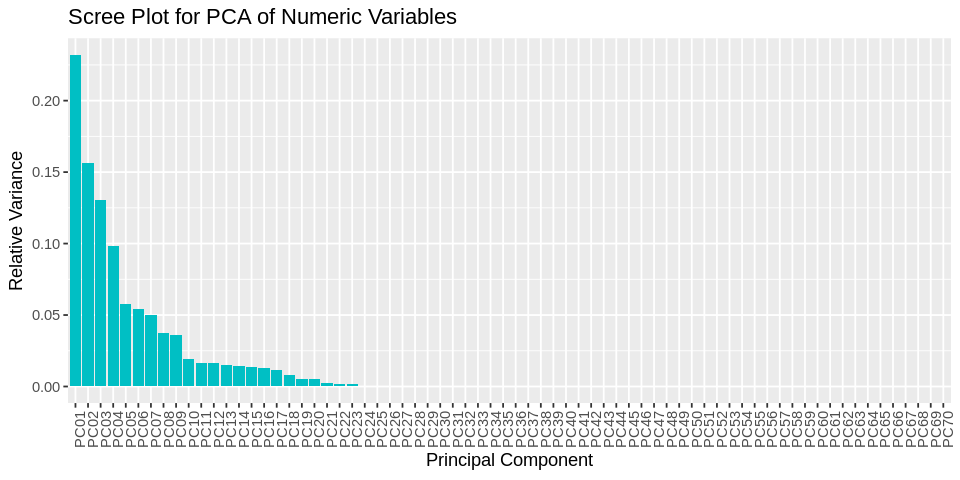

In [26]:
ggplot() +
    geom_col(aes(x=names(importance), y=importance), fill=PALETTE[8]) +
    theme(axis.text.x=element_text(angle=90)) +
    ggtitle("Scree Plot for PCA of Numeric Variables") +
    xlab("Principal Component") + ylab("Relative Variance")

In the cell below, we plot a 3D scatter plot of PCs 1, 2, and 3. Becaue the relative variance of some of the other principal components is so high, however, the plot does not help very much in terms of dimensionality reduction.

null 
   1

HTML widgets cannot be represented in plain text (need html)
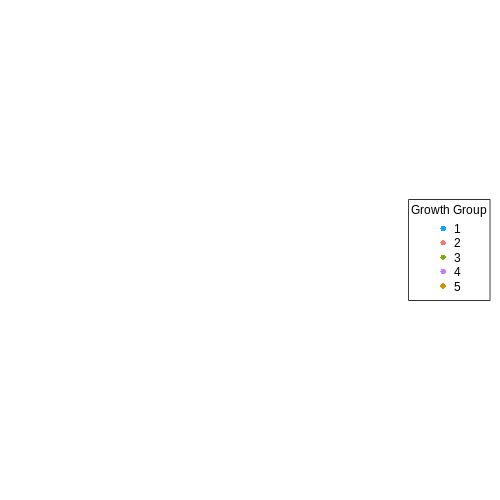

In [27]:
open3d(); view3d(-3)
plot3d(as.data.frame(pc$x)[,c("PC1", "PC2", "PC3")], col=PALETTE[data$growth.group], type="s", alpha=0.3)
par3d(windowRect = c(0, 0, 500, 500))
legend3d("right", legend=1:5, col=PALETTE[1:5], pch=16, inset=c(.02), title="Growth Group")
grid3d(c("x", "y", "z"))
title3d("Principal Component Analysis")
rglwidget(elementId="myplot")

## Cluster Modeling

In this section, we build a cluster model for the data.

### Cluster Model I: Gaussian Mixture Model

The first cluster model will be a Gaussian Mixture Model based on `prclq.q4` and `prccq.2017q2`.

In [28]:
data$c.I = factor(Mclust(data[,c("prclq.q4", "prccq.2017q2")], G=5)$classification)
as.data.frame(table(data$c.I))

Var1 Freq
1 1     919
2 2     209
3 3    1116
4 4     729
5 5      27

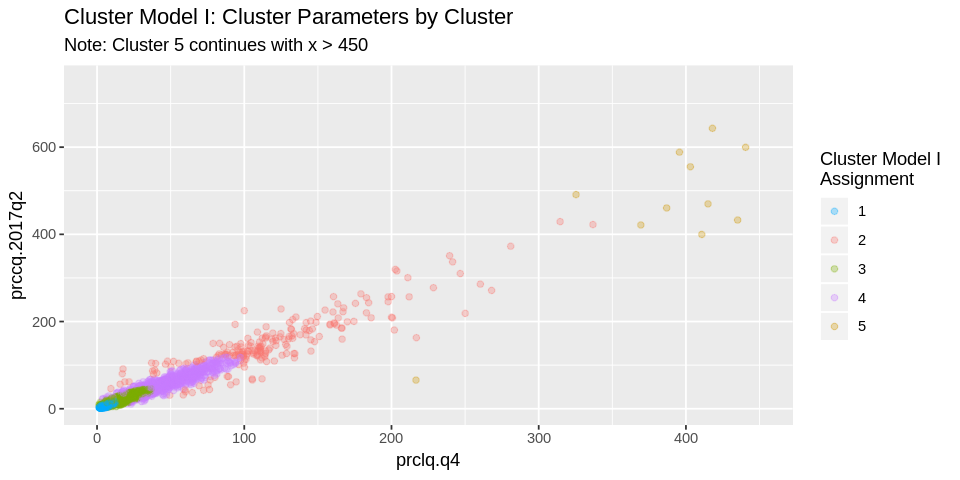

In [29]:
ggplot(data) +
    geom_point(aes(x=prclq.q4, y=prccq.2017q2, col=c.I), alpha=0.3) +
    ggtitle("Cluster Model I: Cluster Parameters by Cluster", "Note: Cluster 5 continues with x > 450") +
    xlim(0,450) + ylim(0,750) +
    scale_color_manual(name="Cluster Model I\nAssignment", values=PALETTE[1:5])

#### Model Evaluation

In the cell below, we calculate the intracluster diffusion for cluster model I.

In [30]:
c1 = data[data$c.I == 1,]$prclq.q4
data.frame(intracluster.diffusion=mean(dist(c1)))

intracluster.diffusion
1 3.730848

To make evaluation of future cluster models easier, we develop a pipline to calculate the mean inctracluster diffusion, mean interclsuter diffusion, and diffusion ratio below. The final pipeline will be solidified in the `diffusion.ratio` function, which will be used to evalute future clusters.

In [31]:
intra.disp = function(data, clu, cols) {
    summary = data.frame(cluster=c(), intracluster.dispersion=c())
    for (cl in unique(data[,clu])) {
        cluster = data[data[,c(clu)] == cl, cols]
        if ((length(dim(cluster)) > 1) && (dim(cluster)[1] == 1)) {
            row_cl = data.frame(cluster=cl, intracluster.dispersion=0)
        } else {
            row_cl = data.frame(cluster=cl, intracluster.dispersion=mean(dist(cluster)))
        }
        summary = rbind(summary, row_cl)
    }
    levels(summary$cluster) = levels(data[,c(clu)])
    summary
}

intra.disp(data, "c.I", c("prclq.q4", "prccq.2017q2"))

cluster intracluster.dispersion
1 1         14.018612            
2 2         31.288665            
3 3         95.074085            
4 4          6.081561            
5 5       2290.192957

In [32]:
mean.intra.disp = function(data, clu, cols) {
    summary = intra.disp(data, clu, cols)
    mean(summary$intracluster.dispersion)
}

mean.intra.disp(data, "c.I", c("prclq.q4", "prccq.2017q2"))

[1] 487.3312

In [33]:
mean.inter.disp = function(data, clu, cols) {
    summary = data.frame(matrix(ncol=length(cols)+1, nrow=0))
    names(summary) = c("cluster", cols)
    for (cl in unique(data[,c(clu)])) {
        cluster = data[data[,c(clu)] == cl, cols]
        if (length(cols) == 1) {
            centroid_cl = as.data.frame(t(mean(cluster)))
            names(centroid_cl) = cols
        } else {
            centroid_cl = t(colMeans(cluster))
        }
        summary = rbind(summary, cbind(data.frame(cluster=cl), centroid_cl))
    }
    levels(summary$cluster) = levels(data[,c(clu)])
    mean(dist(summary[-1]))
}

mean.inter.disp(data, "c.I", c("prclq.q4", "prccq.2017q2"))

[1] 849.241

In [34]:
diffusion.ratio = function(data, clu, cols, verbose=FALSE) {
    intra = mean.intra.disp(data, clu, cols)
    inter = mean.inter.disp(data, clu, cols)
    diffr = inter / intra
    if (verbose) {
        display(data.frame(
            mean.intracluster.diffusion = intra,
            mean.intercluster.diffusion = inter,
            diffusion.ratio = diffr
        ))
    }
    diffr
}

diffusion.ratio(data, "c.I", c("prclq.q4", "prccq.2017q2"), TRUE)

mean.intracluster.diffusion mean.intercluster.diffusion diffusion.ratio
1 487.3312                    849.241                     1.742636

[1] 1.742636

In [35]:
cluster.models = data.frame(model="I", diffusion.ratio=diffusion.ratio(data, "c.I", c("prclq.q4", "prccq.2017q2")))
cluster.models

model diffusion.ratio
1 I     1.742636

### Cluster Model II: Hierarchical Agglomeration

The second cluster model will use hierarchical agglomeration based on `prclq.q4`, `prccq.q4`, and `prccq.q3`.

In [36]:
data.norm = scale(data[,c("prclq.q4", "prccq.q4", "prccq.q3")])

c.II.tree = hclust(dist(data.norm), method="complete")
data$c.II = as.factor(cutree(c.II.tree, k=5))
as.data.frame(table(data$c.II))

Var1 Freq
1 1    2984
2 2       7
3 3       6
4 4       2
5 5       1

null 
   4

HTML widgets cannot be represented in plain text (need html)
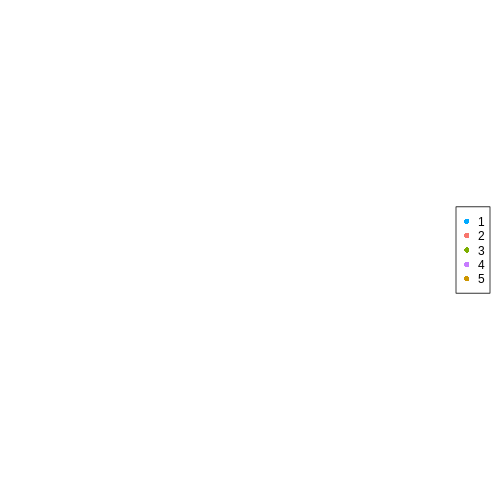

In [37]:
open3d(); view3d(-3)
plot3d(data[,c("prclq.q4", "prccq.q4", "prccq.q3")], col=PALETTE[data$c.II], type="s", alpha=0.3)
par3d(windowRect = c(0, 0, 500, 500))
legend3d("right", legend=1:5, col=PALETTE[1:5], pch=16, inset=c(.02))
grid3d(c("x", "y", "z"))
title3d("Cluster Model II: Cluster Parameters by Cluster")
rglwidget(elementId="myplot")

#### Model Evaluation

In [38]:
diffusion.ratio(data, "c.II", c("prclq.q4", "prccq.q4", "prccq.q3"), TRUE)

mean.intracluster.diffusion mean.intercluster.diffusion diffusion.ratio
1 436.3172                    5126.32                     11.74907

[1] 11.74907

In [39]:
cluster.models = rbind(cluster.models, 
                       data.frame(model="II", diffusion.ratio = diffusion.ratio(data, "c.II", c("prclq.q4", 
                                                                                                "prccq.q4", 
                                                                                                "prccq.q3"))))
cluster.models

model diffusion.ratio
1 I      1.742636      
2 II    11.749067

### Cluster Model III: k-Means

The third cluster model will use k-means based on all of the data.

In [40]:
data$c.III = kmeans(data.norm, 5, nstart=1000)$cluster
as.data.frame(table(data$c.III))

Var1 Freq
1 1       7
2 2      19
3 3    2544
4 4       2
5 5     428

null 
   7

HTML widgets cannot be represented in plain text (need html)
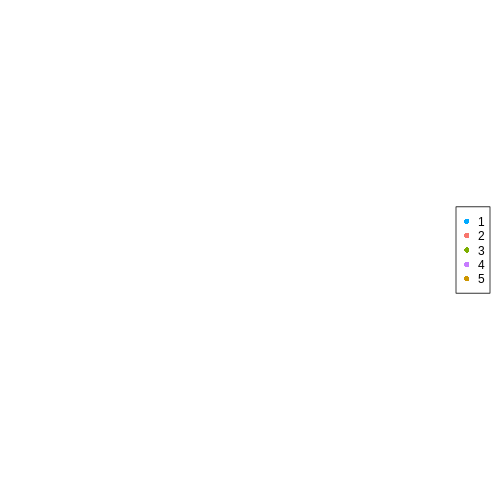

In [41]:
open3d(); view3d(-3)
plot3d(data[,c("prclq.q4", "prccq.q4", "prccq.q3")], col=PALETTE[data$c.III], type="s", alpha=0.3)
par3d(windowRect = c(0, 0, 500, 500))
legend3d("right", legend=1:5, col=PALETTE[1:5], pch=16, inset=c(.02))
grid3d(c("x", "y", "z"))
title3d("Cluster Model III: Cluster Parameters by Cluster")
rglwidget(elementId="myplot")

#### Model Evaluation

In [42]:
diffusion.ratio(data, "c.III", c("prclq.q4", "prccq.q4", "prccq.q3"), TRUE)

mean.intracluster.diffusion mean.intercluster.diffusion diffusion.ratio
1 618.9596                    4792.731                    7.743205

[1] 7.743205

In [43]:
cluster.models = rbind(cluster.models, 
                       data.frame(model="III", diffusion.ratio = diffusion.ratio(data, "c.III", c("prclq.q4", 
                                                                                                  "prccq.q4", 
                                                                                                  "prccq.q3"))))
cluster.models

model diffusion.ratio
1 I      1.742636      
2 II    11.749067      
3 III    7.743205

### Cluster Model IV: Hierarchical Agglomeration

We now cluster using hierarchical agglomeration on all of the columns with 0 `NA` values.

In [44]:
numeric.norm = scale(no.na.numeric)
c.IV.tree = hclust(dist(numeric.norm), method="complete")
data$c.IV = as.factor(cutree(c.IV.tree, k=5))
as.data.frame(table(data$c.IV))

Var1 Freq
1 1    2993
2 2       4
3 3       1
4 4       1
5 5       1

#### Model Evaluation

In [45]:
diffusion.ratio(data, "c.IV", names(no.na.numeric), TRUE)

mean.intracluster.diffusion mean.intercluster.diffusion diffusion.ratio
1 87784.05                    475358.5                    5.41509

[1] 5.41509

In [46]:
cluster.models = rbind(cluster.models, 
                       data.frame(model="IV", diffusion.ratio = diffusion.ratio(data, "c.IV", names(no.na.numeric))))
cluster.models

model diffusion.ratio
1 I      1.742636      
2 II    11.749067      
3 III    7.743205      
4 IV     5.415090

### Cluster Model V: Stochastic Choice

The model below uses a stochastic algorithm with hierarchical agglomeration on random columns to converge to an optimal cluster model.

In [47]:
# stochastic.cluster = function(data, maxiter=1000) {
#     best.cols = NA
#     best.diffr = 0
#     n.cluster = 5
#     for (. in 1:maxiter) {
#         n = sample(1:ncol(numeric.norm), size=1)
#         cols = sample(names(no.na.numeric), size=n)
#         tree = hclust(dist(numeric.norm), method="complete")
#         k = sample(1:10, size=1)
#         cluster = as.factor(cutree(c.IV.tree, k=k))
#         data$new.cluster = cluster
        
#         diffr = diffusion.ratio(data, "new.cluster", cols)
        
#         if (!is.na(diffr)) {
#             if (diffr > best.diffr) {
#                 best.cols = cols
#                 best.diffr = diffr
#                 data$best.cluster = cluster
#             }
#         }
#     }
#     cat(diffusion.ratio(data, "best.cluster", cols, TRUE))
#     data
# }

# data = stochastic.cluster(data)
# head(data)

### Choosing a Cluster Model

Out of all of the models, the best is model II, so we use that for the clusters and remove the other cluster columns from the data.

In [48]:
data$c.I = NULL
data$c.III = NULL
data$c.IV = NULL
data$new.cluster = NULL
data$best.cluster = NULL
data$cluster = data$c.II
data$c.II = NULL

head(data)

gvkey  tic   conm                        datadate.q1 fyearq.q1 fqtr.q1
2484  62527 3AMFC AMB FINANCIAL CORP          2016-03-31  2016      1      
2715  65924 3CSBB CSB BANCORP INC/OH          2016-03-31  2016      1      
1449  21521 3CZFS CITIZENS FINANCIAL SVCS INC 2016-03-31  2016      1      
255  119436 3FBPI FIRST BANCORP INDIANA INC   2016-03-31  2016      3      
2410  61225 3FETM FENTURA FINANCIAL INC       2016-03-31  2016      1      
1105  18301 3FKYS FIRST KEYSTONE CORP         2016-03-31  2016      1      
     fyr.q1 indfmt.q1 consol.q1 popsrc.q1 ⋯ weburl.q4                       
2484 12     INDL      C         D         ⋯ www.acbanker.com                
2715 12     INDL      C         D         ⋯ www.csb1.com                    
1449 12     INDL      C         D         ⋯ www.firstcitizensbank.com       
255   6     INDL      C         D         ⋯ www.firstfedevansville.com      
2410 12     INDL      C         D         ⋯ www.fentura.com                 
1105 12     INDL      C         D         ⋯ www.firstkeystonecorporation.com
     dldte.q4 prccq.2017q2 growth.1  growth.2  growth.3 growth.4  ipodate   
2484 NA       17.00        1.0079194 1.0515873 1.132075 1.1333333 1996-04-01
2715 NA       30.60        1.0391753 0.9988095 1.231625 0.9870968 <NA>      
1449 NA       53.99        1.0680628 0.9882353 1.051587 1.0186792 <NA>      
255  NA       20.80        1.0412698 1.0060976 1.143030 1.1028632 1999-04-07
2410 NA       18.25        0.9016949 1.0902256 1.103448 1.1406250 <NA>      
1105 NA       27.00        0.9611538 0.9803922 1.004082 1.0975610 <NA>      
     growth.group cluster
2484 4            1      
2715 3            1      
1449 2            1      
255  3            1      
2410 3            1      
1105 2            1

In [49]:
as.data.frame(table(data$cluster))

Var1 Freq
1 1    2984
2 2       7
3 3       6
4 4       2
5 5       1

## Exploratory Modeling

In this section, we attempt to build models to predict `growth.4` for exploratory purpose. The final model will be chosen in the next section.

### Model 1: Naive Bayes

The first model will be a Naive Bayes model to predict `growth.group`.

In [50]:
no.na.numeric$growth.group = data$growth.group
model.1 = naiveBayes(growth.group ~ ., no.na.numeric)
prediction.1 = predict(model.1, no.na.numeric)

The confusion matrix for this predictor is given below.

In [51]:
CM.1 = confusionMatrix(prediction.1, no.na.numeric$growth.group)$table
cm.1 = CM.1 / sum(CM.1)
cm.1

          Reference
Prediction            1            2            3            4            5
         1 0.0440000000 0.0220000000 0.0193333333 0.0176666667 0.0203333333
         2 0.0013333333 0.0056666667 0.0003333333 0.0003333333 0.0003333333
         3 0.0013333333 0.0023333333 0.0033333333 0.0023333333 0.0010000000
         4 0.1523333333 0.1690000000 0.1766666667 0.1786666667 0.1573333333
         5 0.0010000000 0.0010000000 0.0003333333 0.0010000000 0.0210000000

#### Model Evaluation

We will use the accuracy of the predictor to evaluate it.

In [52]:
cm.accuracy = function(cm) {
    nclasses = dim(cm)[1]
    diag.sum = 0
    for (i in 1:nclasses) {
        diag.sum = diag.sum + cm[i,i]
    }
    diag.sum / sum(cm)
}

cm.accuracy(cm.1)

[1] 0.2526667

### Model 2: Naive Bayes

This predictor will predict `growth.group` based on `prccq.q4`, `prccq.q3`, and `prclq.q4`.

In [53]:
model.2 = naiveBayes(growth.group ~ prccq.q4 + prccq.q3 + prclq.q4, no.na.numeric)
prediction.2 = predict(model.2, no.na.numeric)

In [54]:
CM.2 = confusionMatrix(no.na.numeric$growth.group, prediction.2)$table
cm.2 = CM.2 / sum(CM.2)
cm.2

          Reference
Prediction            1            2            3            4            5
         1 0.1913333333 0.0060000000 0.0006666667 0.0020000000 0.0000000000
         2 0.1903333333 0.0060000000 0.0020000000 0.0016666667 0.0000000000
         3 0.1806666667 0.0116666667 0.0026666667 0.0050000000 0.0000000000
         4 0.1846666667 0.0093333333 0.0026666667 0.0033333333 0.0000000000
         5 0.1930000000 0.0040000000 0.0016666667 0.0013333333 0.0000000000

#### Model Evaluation

In [55]:
cm.accuracy(cm.2)

[1] 0.2033333

### Model 3: Support Vector Machine

This model will use a support vector machine to predict `growth.group` based on `prccq.q4`, `prccq.q3`, and `prclq.q4`.

In [56]:
model.3 = svm(growth.group ~ prccq.q4 + prccq.q3 + prclq.q4, no.na.numeric)
prediction.3 = predict(model.3, no.na.numeric)

In [57]:
CM.3 = confusionMatrix(no.na.numeric$growth.group, prediction.3)$table
cm.3 = CM.3 / sum(CM.3)
cm.3

          Reference
Prediction           1           2           3           4           5
         1 0.001666667 0.012000000 0.027333333 0.008333333 0.150666667
         2 0.000000000 0.015333333 0.031333333 0.014000000 0.139333333
         3 0.000000000 0.016666667 0.042666667 0.022333333 0.118333333
         4 0.000000000 0.010666667 0.035000000 0.023333333 0.131000000
         5 0.000000000 0.008000000 0.017000000 0.017666667 0.157333333

#### Model Evaluation

In [58]:
cm.accuracy(cm.3)

[1] 0.2403333

### Model 4: OLS

This model will use OLS to predict `growth.4` based on the stock prices and the cluster.

In [59]:
model.4 = lm(growth.4 ~ prccq.q1+prccq.q2+prccq.q3+prccq.q4+cluster, data)
summary(model.4)


Call:
lm(formula = growth.4 ~ prccq.q1 + prccq.q2 + prccq.q3 + prccq.q4 + 
    cluster, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8133 -0.1407 -0.0241  0.1025  3.4990 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.0710869  0.0065072 164.601   <2e-16 ***
prccq.q1    -0.0003022  0.0003491  -0.866   0.3868    
prccq.q2    -0.0001351  0.0004772  -0.283   0.7771    
prccq.q3     0.0012509  0.0005287   2.366   0.0181 *  
prccq.q4    -0.0008347  0.0003716  -2.246   0.0248 *  
cluster2     0.0805450  0.1321357   0.610   0.5422    
cluster3     0.0597737  0.2246248   0.266   0.7902    
cluster4     0.7617667  0.7262092   1.049   0.2943    
cluster5     0.2307275  0.5872297   0.393   0.6944    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2784 on 2991 degrees of freedom
Multiple R-squared:  0.004046,	Adjusted R-squared:  0.001382 
F-statistic: 1.519 on 8 and 2991 DF,  p-value: 0.1

#### Model Evaluation

In the cell below, we define the function `rmse` which will return the RMSE for a model.

In [60]:
rmse = function(actual, predicted) {
    sqrt(mean((actual - predicted)^2))
}

In [61]:
model.4.rmse = rmse(data$growth.4, predict(model.4, data))
model.rmses = data.frame(model=4, rmse=model.4.rmse)
model.rmses

model rmse     
1 4     0.2779455

### Model 5: Neural Network

This model will use a neural network to predict `growth.4` based on the stock prices.

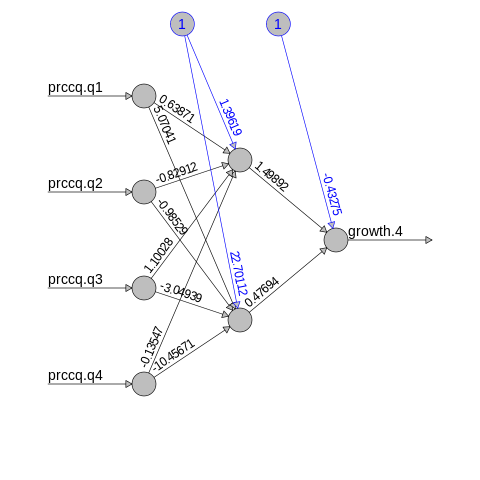

In [62]:
set.seed(12345)
model.5 = neuralnet(growth.4 ~ prccq.q1+prccq.q2+prccq.q3+prccq.q4, data, hidden=2, 
                    algorithm="rprop+", act.fct="logistic", rep=1, linear.output=TRUE)

options(repr.plot.width=4, repr.plot.height=4)
plot(model.5, rep=1, fill="gray", cex=0.7, lwd=0.5, information=FALSE)
options(restore)

#### Model Evaluation

In [63]:
model.5.rmse = rmse(data$growth.4, as.numeric(compute(model.5, data, rep=1)$net.result))
model.rmses = rbind(model.rmses, data.frame(model=5, rmse=model.5.rmse))
model.rmses

model rmse     
1 4     0.2779455
2 5     0.2735361

## Predictive Model

Because the neural network (model 5) seemed to be the best model (lowest RMSE, and predictors all had low accuracy), we will use it to determine whether or not/how much to invest. To determine this, we will use the model to predict `growth.4` and then take the different between the actual and predicted values. If this difference is positive (meaning the stock performed better than predicted), we will invest. The investment in each stock will be porportional to how much better the stock did than the prediction.

To begin, we look at the distribution of the positive differences.

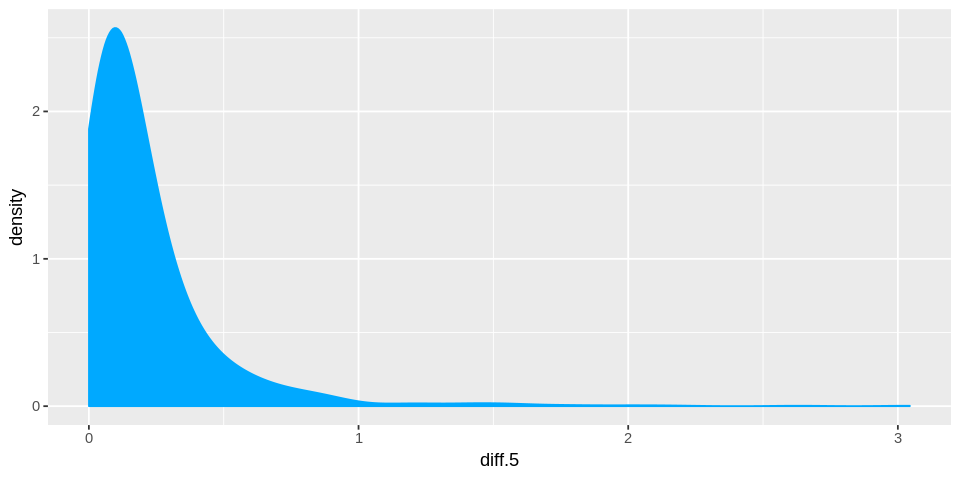

In [64]:
prediction.5 = as.numeric(compute(model.5, data, rep=1)$net.result)
data$diff.5 = data$growth.4 - prediction.5
recommend = data[data$diff.5 > 0,]

ggplot(recommend) +
    geom_density(aes(x=diff.5), kernel="gaussian", fill=PALETTE[1], col=PALETTE[1], bw=.1)

The function `get.prop.investment` returns the amount to invest based on the specification above. As a sanity check, we verify that we have invested all of the money.

In [65]:
get.prop.investment = function(diff) {
    round(budget * diff / sum(recommend$diff.5), digits=2)
}

recommend$invest = sapply(recommend$diff.5, get.prop.investment)

# sanity check
sum(recommend$invest) <= budget

[1] TRUE

### Business Performance Measure

We now calulcate the business performance measure on this model.

In [66]:
insample_bpm = sum(recommend$invest * recommend$growth.4) - budget
data.frame(insample_bpm)

insample_bpm
1 626023.8

### Modeling Recommendations

Now we add the recommended investment to the data and then we will use this to build a final model which will be applied to the new data.

In [67]:
data$investment = 0
data[data$tic %in% recommend$tic,]$investment = recommend$invest
head(data)

gvkey  tic   conm                        datadate.q1 fyearq.q1 fqtr.q1
2484  62527 3AMFC AMB FINANCIAL CORP          2016-03-31  2016      1      
2715  65924 3CSBB CSB BANCORP INC/OH          2016-03-31  2016      1      
1449  21521 3CZFS CITIZENS FINANCIAL SVCS INC 2016-03-31  2016      1      
255  119436 3FBPI FIRST BANCORP INDIANA INC   2016-03-31  2016      3      
2410  61225 3FETM FENTURA FINANCIAL INC       2016-03-31  2016      1      
1105  18301 3FKYS FIRST KEYSTONE CORP         2016-03-31  2016      1      
     fyr.q1 indfmt.q1 consol.q1 popsrc.q1 ⋯ prccq.2017q2 growth.1  growth.2 
2484 12     INDL      C         D         ⋯ 17.00        1.0079194 1.0515873
2715 12     INDL      C         D         ⋯ 30.60        1.0391753 0.9988095
1449 12     INDL      C         D         ⋯ 53.99        1.0680628 0.9882353
255   6     INDL      C         D         ⋯ 20.80        1.0412698 1.0060976
2410 12     INDL      C         D         ⋯ 18.25        0.9016949 1.0902256
1105 12     INDL      C         D         ⋯ 27.00        0.9611538 0.9803922
     growth.3 growth.4  ipodate    growth.group cluster diff.5      investment
2484 1.132075 1.1333333 1996-04-01 4            1        0.06717384 248.88    
2715 1.231625 0.9870968 <NA>       3            1       -0.07907819   0.00    
1449 1.051587 1.0186792 <NA>       2            1       -0.04749573   0.00    
255  1.143030 1.1028632 1999-04-07 3            1        0.03669037 135.94    
2410 1.103448 1.1406250 <NA>       3            1        0.07445193 275.84    
1105 1.004082 1.0975610 <NA>       2            1        0.03138600 116.28

## Investment Model

In this section, we build the model to predict the amount to invest in each stock. We will only consider investing in stocks in `recommend`.

In [68]:
no.na.numeric$investment = data$investment
no.na.numeric = no.na.numeric[,!(names(no.na.numeric) %in% c("growth.group"))]
no.na.numeric = no.na.numeric[data$tic %in% recommend$tic,]

model.1 = lm(investment ~ prccq.q1+prccq.q2+prccq.q3+prccq.q4, no.na.numeric)
model.2 = neuralnet(investment ~ prccq.q1+prccq.q2+prccq.q3+prccq.q4, no.na.numeric, hidden=2, 
                    algorithm="rprop+", act.fct="logistic", rep=1, linear.output=TRUE)
model.3 = svm(investment ~ prccq.q1+prccq.q2+prccq.q3+prccq.q4, no.na.numeric, kernel="linear")
model.4 = svm(investment ~ prccq.q1+prccq.q2+prccq.q3+prccq.q4, no.na.numeric, kernel="polynomial")
model.5 = svm(investment ~ prccq.q1+prccq.q2+prccq.q3+prccq.q4, no.na.numeric, kernel="radial")
model.6 = svm(investment ~ prccq.q1+prccq.q2+prccq.q3+prccq.q4, no.na.numeric, kernel="sigmoid")

In [69]:
rmse.1 = rmse(no.na.numeric$investment, predict(model.1, no.na.numeric))
rmse.2 = rmse(no.na.numeric$investment, as.numeric(compute(model.2, no.na.numeric, rep=1)$net.result))
rmse.3 = rmse(no.na.numeric$investment, predict(model.3, no.na.numeric))
rmse.4 = rmse(no.na.numeric$investment, predict(model.4, no.na.numeric))
rmse.5 = rmse(no.na.numeric$investment, predict(model.5, no.na.numeric))
rmse.6 = rmse(no.na.numeric$investment, predict(model.6, no.na.numeric))

data.frame(model=1:6, rmse=c(rmse.1, rmse.2, rmse.3, rmse.4, rmse.5, rmse.6))

model rmse      
1 1       969.4697
2 2       971.9419
3 3      1011.4008
4 4      1012.1956
5 5       995.0457
6 6     18068.2217

Model 1 has lowest RMSE so we'll use that.

## Decision

To decide on the investments we load in the new data below and merge it into a single dataframe `data.new`. We also extract the numeric variables with no `NA` values as before.

In [79]:
data.new.q1 = read.csv("../data/Company Fundamentals 2018-Q1.csv", header=TRUE)
data.new.q2 = read.csv("../data/Company Fundamentals 2018-Q2.csv", header=TRUE)
data.new.q3 = read.csv("../data/Company Fundamentals 2018-Q3.csv", header=TRUE)
data.new.q4 = read.csv("../data/Company Fundamentals 2018-Q4.csv", header=TRUE)

In [81]:
m12 = merge(data.new.q1, data.new.q2, by=c("gvkey", "tic", "conm"), suffixes=c(".q1",".q2"))
m34 = merge(data.new.q3, data.new.q4, by=c("gvkey", "tic", "conm"), suffixes=c(".q3",".q4"))
m1234 = merge(m12, m34, by=c("gvkey", "tic", "conm"))

data.new = m1234[order(m1234$tic),]

In [98]:
numeric.vars = data.new[, unlist(lapply(data.new, is.numeric))]
na.sums = colSums(is.na(numeric.vars))
no.na.numeric = numeric.vars[,names(na.sums[(na.sums == 0) & (names(na.sums) %in% names(numeric.vars))])]
# no.na.numeric = no.na.numeric[data.new$tic %in% recommend$tic,]

In [99]:
no.na.numeric

gvkey  datadate.q1 fyearq.q1 fqtr.q1 fyr.q1 ajexq.q1 ajpq.q1 updq.q1
881 179137 20160331    2016      1       12     1.0      1.0     3      
820 178578 20160331    2016      1       12     1.0      1.0     3      
22  160788 20160331    2016      1       12     1.0      1.0     3      
829 178698 20160331    2016      1       12     1.0      1.0     3      
334 166272 20160331    2016      1       12     1.0      1.0     3      
676 176939 20160331    2016      1       12     1.0      1.0     3      
317 165981 20160331    2016      1       12     1.0      1.0     3      
870 179048 20160331    2016      1       12     1.0      1.0     3      
38  161048 20160331    2016      1       12     1.0      1.0     3      
225 164506 20160331    2016      1       12     1.0      1.0     3      
478 174136 20160331    2016      1       12     1.0      1.0     3      
555 175493 20160331    2016      1       12     1.0      1.0     3      
157 163708 20160331    2016      1       12     1.0      1.0     3      
226 164511 20160131    2016      1       10     1.0      1.0     3      
599 176092 20160331    2016      1       12     1.0      1.0     3      
598 176083 20160331    2015      4        3     1.0      1.0     3      
719 177446 20160331    2016      1       12     1.0      1.0     3      
319 166005 20160331    2016      1       12     1.0      1.0     3      
833 178720 20160331    2016      3        6     1.0      1.0     3      
148 163626 20160331    2016      1       12     1.0      1.0     3      
898 179288 20160331    2016      1       12     1.0      1.0     3      
336 166363 20160331    2016      1       12     1.0      1.0     3      
203 164190 20160331    2016      1       12     1.0      1.0     3      
269 165407 20160331    2016      1       12     1.0      1.0     3      
612 176247 20160331    2016      1       12     1.0      1.0     3      
321 166087 20160331    2016      1       12     1.0      1.0     3      
333 166270 20160229    2015      4        2     1.0      1.0     3      
520 175007 20160331    2016      1       12     1.0      1.0     3      
594 176021 20160331    2016      1       12     1.0      1.0     3      
535 175236 20160331    2016      1       12     0.1      0.1     3      
⋮   ⋮      ⋮           ⋮         ⋮       ⋮      ⋮        ⋮       ⋮      
504 174490 20160331    2016      1       12     1.0000   1.0000  3      
40  161069 20160331    2016      1       12     1.0000   1.0000  3      
577 175654 20160331    2016      1       12     1.0000   1.0000  3      
10  160684 20160331    2016      1       12     1.0000   1.0000  3      
666 176832 20160331    2016      1       12     1.0000   1.0000  3      
537 175264 20160331    2015      4        3     1.0000   1.0000  3      
547 175379 20160331    2016      1       12     0.0286   0.0286  3      
179 163921 20160331    2016      1       12     1.0000   1.0000  3      
485 174280 20160331    2016      1       12     1.0000   1.0000  3      
218 164365 20160331    2016      1       12     1.0000   1.0000  3      
536 175263 20160331    2016      1       12     1.0000   1.0000  3      
512 174729 20160331    2016      1       12     1.0000   1.0000  3      
107 162564 20160331    2016      1       12     1.0000   1.0000  3      
868 179029 20160331    2016      1       12     1.0000   1.0000  3      
87  162400 20160331    2016      1       12     1.0000   1.0000  3      
884 179147 20160331    2016      1       12     1.0000   1.0000  3      
734 177629 20160331    2016      1       12     1.0000   1.0000  3      
280 165554 20160331    2016      1       12     1.0000   1.0000  3      
554 175490 20160331    2016      1       12     0.1000   0.1000  3      
278 165540 20160331    2016      1       12     1.0000   1.0000  3      
378 170373 20160331    2016      1       12     1.0000   1.0000  3      
765 177975 20160331    2016      1       12     1.0000   1.0000  3      
592 176007 20160331    2016      1       12     0.2000   0.200

In the cell below, we apply model 1 to the new data.

In [101]:
prediction = predict(model.1, no.na.numeric)
investments = data.frame(tic=data.new$tic, invest=prediction)
size(investments)
head(investments)

observations variables
1 915          2

tic    invest  
881 3ACLZ  748.1915
820 3SPKMF 747.8195
22  3TDCB  743.7497
829 AAC    739.6260
334 ABCAF  747.3651
676 ABCD   749.6756

Because the investments don't add up to `budget` we will scale them by multiplying the budget times $\frac{\text{investment}_i}{\sum \text{investments}}$.

In [102]:
get.investment = function(i) {
    round(budget * i / sum(investments$invest), digits=2)
}

investments$invest = sapply(investments$invest, get.investment)

# sanity check
sum(investments$invest)

[1] 999999.9

Because there is a \\$0.01 discrepancy, this cent will be added to the largest investment.

In [103]:
max.investment = investments[investments$invest == max(investments$invest),]$invest[1]
max.investment = max.investment + 0.05
investments[investments$invest == max(investments$invest),]$invest[1] = max.investment
sum(investments$invest)

[1] 1e+06

Finally, we add back in the stocks in which we invested \\$0 and write the CSV file.

In [104]:
recommend = data.frame(tic=data.new$tic)
recommend$invest = 0
recommend[recommend$tic %in% investments$tic,]$invest = investments$invest
head(recommend)

tic    invest 
1 3ACLZ  1095.53
2 3SPKMF 1094.98
3 3TDCB  1089.02
4 AAC    1082.99
5 ABCAF  1094.32
6 ABCD   1097.70

In [105]:
write.csv(recommend, "../data/Chris Pyles Recommendation B 2018.csv", row.names=FALSE)

## Reflection

This project helped me to put to practice the tools we have been developing through lecture and homework assignments. Because the pedagogical data in the homeworks is so clean and tidy, this project puts into perspective how different it is to use actual, real world data to answer business questions. It was also great practice in thinking through the entire analytical method, form EDA, to modeling, to refining models, and then to making predictions.

This project was also great for thinking about how to use data in multiple ways. Because I was able to work on it throughout the course, I got to experience the analytical methods in real-time, which enahnced my understanding of the material. I also got to think through how to approach using predictors in data without categorical variables and when it is advantageous to create rendered variables. I also think that this project is a good exercise in learning the importance of and how to document code, as it is something you come back to multiple times throughout the course and you need to be able to understand what you've already done.

Finally, I think that the project was great in how it highlights _business_ metrics as opposed to general model performance measures. Most data science courses teach you about RMSE and MAPE, but they don't consider the case when the goal isn't necessarily to have an accurate model but some other outcome. The project is great in that it highlights the fact that you can have a relatively inaccurate model but as long as it makes the highest profit, it is the model you'll choose because _that_ is your desired outcome.